## 1. BreaKHis Challenge (50 points)

Breast Cancer Histopathological Database (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients. To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).

You are required to implement a CNN-based model to finish an image binary classification task for a subset of the BreakHis dataset that only contains images of 400x optical magnification. There are two classes in this dataset: benign tumors and malignant tumors, where benign corresponds to label 0 and malignant corresponds to label 1. The folder names describe the labels of the data they contain. 


**Grading Criteria:**

1. The code should execute without syntax errors. If the code fails to execute, your score for this whole question will be zero.

2. [40 points] The evaluation metric for the model is accuracy, with a minimum threshold of 0.7, corresponding to a base score of 20 points. For every increase of 0.01 in accuracy above this threshold, an additional point will be awarded. When the accuracy reaches or exceeds 0.9, you can obtain the maximum score of 40 points for this section. For example, if the accuracy is 0.86, then the corresponding score is $20 + (0.86 - 0.7) * 100 = 36$.

$$
Accuracy = \frac{TP+TN}{TP+FP+TN+FN}
$$

3. [10 points] You are required to provide a brief description of the deep learning model you use and explain the reasons why you choose it. The word limit for this section is 500 words, and the maximum score is 10 points. Evident inconsistencies between your description and the implemented model may lead to deductions in the corresponding score for this section. Also, exceeding the word limit will also lead to a deduction of points for this section.

4. Your code outputs should include: 
   - Training loss curve.
   - Accuracy on the test set.


**Requirements:**

1. You are required to complete your programming assignment on this Jupyter notebook and ensure that all code outputs are captured within this file for reproducibility. Other forms of submission (for example, an additional Python script) will not be accepted.

2. You must independently implement the deep learning model you utilize from scratch. Direct usage of convenient API interfaces such as those from `torch.hub` or HuggingFace `transformers` to accomplish this task is not permitted.

3. While the use of pre-trained model weights is allowed for this assignment, it is mandated that you fine-tune the pre-trained model. Directly utilizing pre-trained weights for inference on the test set is not permitted.

4. In this question, only deep learning methods based on convolutional neural networks (CNNs) are permitted. Other models such as the traditional machine learning methods with hand-crafted feature extraction methods (such as SIFT, HOG, etc.), Transformer-based models (such as vision Transformer, Swin Transformer, etc.), or the MLP-mixer and its variants, are not permitted to use.

5. You are not allowed to use additional data for training or fine-tuning.

6. Fine-tuning the model by using the test set is strictly prohibited. If you are found to do so, your score for this question will be zero.


### Download BreaKHis Dataset

In [119]:
# download the dataset (file size: 842 MB, downloading time usage: ~7 min)
!wget -c https://zenodo.org/records/10100993/files/BreakHis.zip

# unzip the dataset
!unzip BreaKHis.zip

# remove the archive (optional)
# !rm -rf BreaKHis.zip

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

Current device: cuda


In [122]:
def calculate_accuracy(model,data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        images, labels = next(iter(data_loader))
        model.eval()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 获取每个样本的预测类别
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [123]:

# 定义数据变换（预处理）
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图像大小
    transforms.ToTensor(),         # 将图像转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 加载训练数据集
train_dataset = ImageFolder(root='./BreakHis/train', transform=transform)
test_dataset = ImageFolder(root='./BreakHis/test', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# 创建CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x,0.5,True)
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
## optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
epoch_list = []
loss_list = []
test_score_list = []
'''
for epoch in range(50):
    images, labels = next(iter(train_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_accuracy = calculate_accuracy(test_loader)
    epoch_list.append(epoch+1)
    loss_list.append(loss.item())
    test_score_list.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
'''
for epoch in range(50):  # 训练10个epoch，可以根据需要调整
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    model.eval()
    test_accuracy = calculate_accuracy(model.to('cpu'), test_loader)
    model.train()
    model.to('cuda')
    epoch_list.append(epoch+1)
    loss_list.append(running_loss / len(train_loader))
    test_score_list.append(test_accuracy)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
print('Finished Training')


Epoch 1, Loss: 0.5648111038737826
Epoch 2, Loss: 0.47541263533963096
Epoch 3, Loss: 0.4124585414926211
Epoch 4, Loss: 0.40151598387294346
Epoch 5, Loss: 0.39138885421885383
Epoch 6, Loss: 0.37143537319368786
Epoch 7, Loss: 0.35776106350951725
Epoch 8, Loss: 0.37566181851757896
Epoch 9, Loss: 0.343033567070961
Epoch 10, Loss: 0.3299863346748882
Epoch 11, Loss: 0.3276420616441303
Epoch 12, Loss: 0.32204024328125846
Epoch 13, Loss: 0.3146468359563086
Epoch 14, Loss: 0.30894141727023655
Epoch 15, Loss: 0.28545916577180225
Epoch 16, Loss: 0.29787439935737187
Epoch 17, Loss: 0.30384234173430336
Epoch 18, Loss: 0.27387474560075337
Epoch 19, Loss: 0.24951809810267556
Epoch 20, Loss: 0.24370230568779838
Epoch 21, Loss: 0.22248096350166532
Epoch 22, Loss: 0.20983175685008368
Epoch 23, Loss: 0.20770312514570025
Epoch 24, Loss: 0.1963054041067759
Epoch 25, Loss: 0.20837477387653458
Epoch 26, Loss: 0.20023956149816513
Epoch 27, Loss: 0.17599940217203563
Epoch 28, Loss: 0.21995198064380223
Epoch 29,

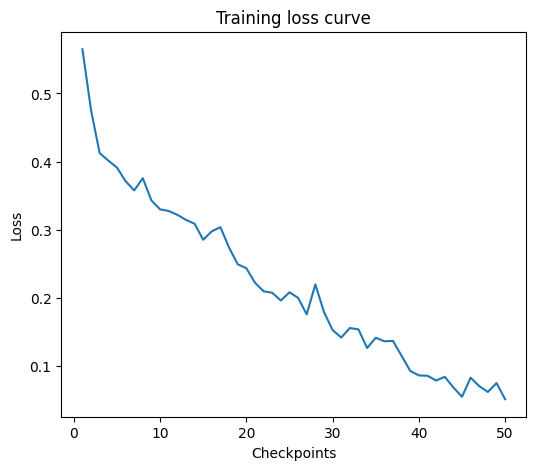

In [124]:
# loss curve visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(epoch_list,loss_list)
plt.xlabel("Checkpoints")
plt.ylabel("Loss")
plt.title("Training loss curve")
plt.show()

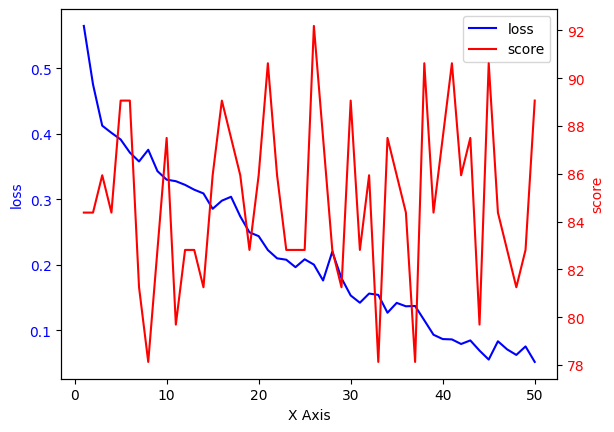

In [125]:
fig, ax1 = plt.subplots()

# 绘制第一个数据和设置标签
ax1.plot(epoch_list, loss_list, label='loss', color='b')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个坐标轴并绘制数据
ax2 = ax1.twinx()
ax2.plot(epoch_list, test_score_list, label='score', color='r')
ax2.set_ylabel('score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

# 显示图形
plt.show()

In [128]:
# 此处计算在验证集二十次验证的平均值
model.eval()
score_sum = 0
count = 0
for epoch in range(20):
    count = count + 1
    test_accuracy = calculate_accuracy(model.to('cpu'), test_loader)
    score_sum = test_accuracy + score_sum

print(score_sum,count,score_sum/count)


1682.8125 20 84.140625
